# **Single Fingerprint Deep Classification**
### **JCE - Software Engineering Final Project** 
##### ***By Kobi Amsellem & Zohar Kedem***

##### In this study we want to discovare if Deep Convolutional Neural Network can classify single fingerprint image to find the owner: 
##### **1. Gender** - 2 classes (male/female).
##### **2. Finger name** - 10 classes (right-thumb, ..., right-thumb, ...)
##### **3. Fingerprint type** - 5 classes (left loop, whirl, right loop, tented arch, arch)
##### **4. Same Person** - 2 classes (Same, Different) *(whether or not two fingerprints belong to the same personperson)* 


In [1]:
import os
import copy
import numpy as np
import datasets as ds
import tensorflow as tf
import FPMLmodule.utils as utils
import FPMLmodule.backbones as bb
import FPMLmodule.classifiers as cf
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from FPMLmodule.fpml import FPML 
from pathlib import Path

print('TensorFlow Version:', tf.__version__)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
dbStudyOutPath ='./out/{}/'

weightsRN50 = "./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsMNV2 = "./weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
weightsENB2 = "./weights/efficientnetb2_notop.h5"
weightsINCEPTIONV3 = "./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsXCEPTION = "./weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

TensorFlow Version: 2.8.0


#### **Model Search** 
##### Main method to search after the best model

in this section we define the ````researchBestModel````, a method to search and compare between several different models and hyper parameters and choose the best one for specific dataset.

##### **Stages:**
##### **1.** Backbone Transfer Learning mode comparison - (a) Pretraind wheights and Untrainable, (b) Pretraind wheights and Trainable, (c) Initialize wheight and Trainable.
##### **2.** Backbone comparison. 
##### **3.** Loss function comparison. 
##### **4.** Learning rates comparison. 
##### **5.** Optimizers comparison. 
##### **6.** Train best configuration for extra epochs on train+validation datasets

In [2]:
def researchBestModel(configureDS, datasets, epochsSearch, epochsBest, path, optimizers, learningRates, defaultHypers, losses, classifiers, defaultClassifier, defaultBackbone, backbonesForSearch, verbose=1):
    
    trainDs, testDs, valDs = datasets
    imgDim = configureDS.inputDim
    nbClasses = len(configureDS.classNames)
    outFilePath = path + 'ablationHistory.csv'
    
    print('Ablation for', configureDS.name)
    
    
    baseStudy = {
            "architecture": {
                "backbone": defaultBackbone['backbone'](imgDim, weights=defaultBackbone['weights'], trainable=False),
                "classifier": defaultClassifier(nbClasses, "softmax"),
                "inputLayer": None, 
                "inputDim": imgDim
            },
            "hyperparameters": defaultHypers
        }
    
    # --------------------------------------------------
    # ---- Stage 1 - Compare Transfer Learning Mode ----
    # --------------------------------------------------
    
    trainingModeStudy = baseStudy
    trainingModeStudy['architecture']['backbone'] = [
                    defaultBackbone['backbone'](imgDim, weights=defaultBackbone['weights'], trainable=False, name='PT&Untrainable'),
                    defaultBackbone['backbone'](imgDim, weights=defaultBackbone['weights'], trainable=True, name='PT&Trainable'),
                    defaultBackbone['backbone'](imgDim, weights=None, trainable=True, name='IN&Trainable')
                    ]    
    trainingModeHistories = utils.researchStudies(trainDs, valDs, {'DNN-TransferLearningMode' : trainingModeStudy}, epochsSearch, verbose)
    bestTrainMode = utils.getBestStudyFromHistories(trainingModeHistories)
    trainable, pretrained = 'Trainable' in bestTrainMode, 'PT' in bestTrainMode
    utils.displayStudiesProgress(trainingModeHistories, path, 'Comparison Transfer Learning Mode')
    utils.saveStudyHistory({'DNN-TransferLearningMode' : trainingModeStudy}, trainingModeHistories, outFilePath)
    print("Backbone Transfer Learning Mode Selected - Pretrained:", pretrained, 'Trainable:', trainable)
    
    
    # ------------------------------------------
    # ---- Stage 2 - Compare DNN Backbones -----
    # ------------------------------------------
    backboneConfigs = [backbone['backbone'](imgDim, weights=backbone['weights'], trainable=trainable) for backbone in backbonesForSearch]
    bestBackboneStudy = copy.deepcopy(trainingModeHistories[bestTrainMode]['config'])
    bestBackboneStudy["architecture"]["backbone"] = backboneConfigs
    bestBackboneHistories = utils.researchStudies(trainDs, valDs, {'Backbone': bestBackboneStudy}, epochsSearch, verbose)
    bestBackboneHistories['Backbone'+"_"+defaultBackbone['backbone'].__name__] = trainingModeHistories[bestTrainMode]
    bestBackbone = utils.getBestStudyFromHistories(bestBackboneHistories)
    utils.displayStudiesProgress(bestBackboneHistories, path, 'Comparison DNN Backbone')
    utils.saveStudyHistory({'BestBackbone': bestBackboneStudy}, bestBackboneHistories, outFilePath)
    print("Best DNN Backbone:", bestBackboneHistories[bestBackbone]['config']["architecture"]["backbone"].name)


    # --------------------------------------------
    # ---- Stage 2.5 - Compare FC Classifiers ----
    # --------------------------------------------
    classifierStudy = copy.deepcopy(bestBackboneHistories[bestBackbone]['config'])
    classifierStudy['architecture']["classifier"] = [classifier(nbClasses, "softmax") for classifier in classifiers]
    classifierHistories = utils.researchStudies(trainDs, valDs, {'Classifiers': classifierStudy}, epochsSearch, verbose)
    classifierHistories['Classifier'+"_"+str(defaultClassifier.__name__)] = bestBackboneHistories[bestBackbone]
    bestClassifier = utils.getBestStudyFromHistories(classifierHistories)
    utils.displayStudiesProgress(classifierHistories, path, 'Comparison Classifiers')
    utils.saveStudyHistory({'bestClassifier': classifierStudy}, classifierHistories, outFilePath)
    print("Best Classifier:", str(classifierHistories[bestClassifier]['config']['architecture']["classifier"]))
    
    # ------------------------------------------
    # ---- Stage 3 - Compare Loss Functions ----
    # ------------------------------------------
    lossStudy = copy.deepcopy(classifierHistories[bestClassifier]['config'])
    lossStudy['hyperparameters']["loss"] = losses
    lossesHistories = utils.researchStudies(trainDs, valDs, {'LossFunction': lossStudy}, epochsSearch, verbose)
    lossesHistories['LossFunction'+"_"+str(defaultHypers["loss"])] = classifierHistories[bestClassifier]
    bestLoss = utils.getBestStudyFromHistories(lossesHistories)
    utils.displayStudiesProgress(lossesHistories, path, 'Comparison Loss Functions')
    utils.saveStudyHistory({'BestLoss': lossStudy}, lossesHistories, outFilePath)
    print("Best Loss Function:", str(lossesHistories[bestLoss]['config']['hyperparameters']["loss"]))
    
    
    # ------------------------------------------
    # ---- Stage 4 - Compare Learning Rates ----
    # ------------------------------------------
    learningRatesStudy = copy.deepcopy(lossesHistories[bestLoss]['config'])
    learningRatesStudy['hyperparameters']['learningRate'] = learningRates
    learningRatesHistories = utils.researchStudies(trainDs, valDs, {'LearningRate': learningRatesStudy}, epochsSearch, verbose)
    learningRatesHistories['LearningRate'+"_"+str(defaultHypers["learningRate"])] = lossesHistories[bestLoss]
    bestLearningRate = utils.getBestStudyFromHistories(learningRatesHistories)
    utils.displayStudiesProgress(learningRatesHistories, path, 'Comparison Learning Rate')
    utils.saveStudyHistory({'BestLearningRate': learningRatesStudy}, learningRatesHistories, outFilePath)
    print("Best Learning Rate:", str(learningRatesHistories[bestLearningRate]['config']["hyperparameters"]["learningRate"]))


    # --------------------------------------
    # ---- Stage 5 - Compare Optimizers ----
    # --------------------------------------
    optimizersStudy = copy.deepcopy(learningRatesHistories[bestLearningRate]['config'])
    optimizersStudy["hyperparameters"]["optimizer"] = optimizers
    optimizersHistories = utils.researchStudies(trainDs, valDs, {'Optimizer' : optimizersStudy}, epochsSearch, verbose)
    optimizersHistories['Optimizer'+"_"+defaultHypers['optimizer'].__name__] = learningRatesHistories[bestLearningRate]
    bestOptimizier = utils.getBestStudyFromHistories(optimizersHistories)
    utils.displayStudiesProgress(optimizersHistories, path, 'Comparison Optimizer')
    utils.saveStudyHistory({'BestOptimizier': optimizersStudy}, optimizersHistories, outFilePath)
    print("Best Optimizier:", optimizersHistories[bestOptimizier]['config']["hyperparameters"]["optimizer"].__name__)
    


    # ---------------------------------------------------------
    # ---- Stage 6 - Train Best model on train+validation -----
    # ---------------------------------------------------------
    bestModelConfiguration = optimizersHistories[bestOptimizier]['config']
    trainValDs = trainDs.concatenate(valDs)

    bestModel = FPML(**bestModelConfiguration["architecture"]).create(**bestModelConfiguration["hyperparameters"])
    bestModelHistory = bestModel.fit(trainValDs, validation_data=testDs, epochs=epochsBest, verbose=verbose)
    toSave = {'Best Model':{'history' : bestModelHistory, 'config' : bestModelConfiguration}}
    utils.displayStudiesProgress(toSave, path, 'Best Model')
    utils.saveStudyHistory({'Best Model': bestModelConfiguration}, toSave, outFilePath)
    utils.displayConfusion(testDs, bestModel, path)
    
    bestModel.save(path+configureDS.name+'.h5py')
    return bestModel, bestModelConfiguration


In [7]:

def evaluteStudyOnOthersDatasets(bestModels, datasets, epochsFinal, verbose=1, path=None):
    
    bestModelName = None
    bestModelAcc = 0
    finalDs = None
    
    for modelName, model in  bestModels.items():
        chainedTrain = None
        chainedTest = None
        for dset in datasets:
            dset.split = [1]
            [toConcat] = dset.create()
            
            if(dset.name != modelName):
                if chainedTrain == None:
                    chainedTrain = toConcat
                else:
                    chainedTrain = chainedTrain.concatenate(toConcat)
            else:
                if chainedTest == None:
                    chainedTest = toConcat
                else:
                    chainedTest.concatenate(toConcat)
        
        evaluation = model[0].evaluate(chainedTrain)
        if(bestModelAcc < evaluation[1]):
            bestModelName = modelName
            bestModelAcc = evaluation[1]
            finalDs = {'train' : chainedTrain, 'test': chainedTest}
    

    finalModelConfiguration = bestModels[bestModelName][1]
    finalModel = FPML(**finalModelConfiguration["architecture"]).create(**finalModelConfiguration["hyperparameters"])
    finalModelHistory = finalModel.fit(finalDs['train'], validation_data=finalDs['test'], epochs=epochsFinal, verbose=verbose)
    
    utils.datasetAnalysisAndDisplay([finalDs['train'], finalDs['test']], datasets[0], path)
    
    toSave = {'Final Model':{'history' : finalModelHistory, 'config' : finalModelConfiguration}}
    
    utils.displayStudiesProgress(toSave, path, 'Final Model')
    utils.saveStudyHistory({'Final Model': finalModelConfiguration}, toSave, path+'finalModel.csv')
    utils.displayConfusion(finalDs['test'], finalModel, path)


def researchStudy(study, finalModelEpochs, path=None):
    datasets = study['datasets']
    studyParams = study['studyHyperParameters']
    preparedDatasets = utils.prepareDatasetsForStudy(datasets, path)
    bestModels = {}
    for dsName, dsObj in preparedDatasets.items():
        bestModels[dsName] = researchBestModel(**dsObj, **studyParams)
    
    Path(path.format('FinalModel')).mkdir(parents=True, exist_ok=True)
    evaluteStudyOnOthersDatasets(bestModels, datasets, finalModelEpochs, 1, path.format('FinalModel'))
    return bestModels


##### **Datasets Configuration**

In [4]:
datasetsConfig = {
    'batchSize': 32, 
    'parallelTune': tf.data.AUTOTUNE, 
    'split': [0.7, 0.15, 0.15], 
    'inputDim': (224, 224, 3), 
    'seed': 9, 
    'shuffle': True
    }

#### **1. Gender Study** 
##### **Datasets**
* **SOCOFing**
* **NIST Special Database 4**

##### **Hyperparameters**
* Optimizers: *Adam, Nadam, RMSprop*
* Loss Functions: *binary-crossentropy, binary-focal-crossentropy, hinge*
* Learning Rates: *0.1, 0.01, 0.001, 0.0001, 0.00001*
* Backbones: *MobileNetV2, ResNet50, EfficientNetB2, InceptionV3, Xception*


In [5]:
genderStudy = {
    'datasets' : [
        ds.SOCOFingGender(**datasetsConfig, sampling=ds.SOCOFingGender.UNDER_SAMPLING),
        ds.NISTSDB4Gender(**datasetsConfig)
    ],
    'studyHyperParameters' : {
        'defaultBackbone': {'backbone' : bb.MobileNetV2, 'weights' : weightsMNV2},
        'defaultClassifier': cf.DefaultClassifier,
        'defaultHypers': {
            "optimizer": Adam,
            "learningRate": 0.001,
            "loss": 'binary_crossentropy',
            "metrics": 'accuracy'
        },
        'losses': ['binary_focal_crossentropy', 'hinge'],
        'learningRates': [0.1, 0.01, 0.0001, 0.00001],
        'optimizers': [Nadam, RMSprop],
        'classifiers': [cf.AlexNetClassifier, cf.MobileNetClassifier, cf.ResNetClassifier],
        'backbonesForSearch': [
            {'backbone' : bb.ResNet50, 'weights' : weightsRN50},
            {'backbone' : bb.EfficientNetB2, 'weights' : weightsENB2},
            {'backbone' : bb.InceptionV3, 'weights' : weightsINCEPTIONV3},
            {'backbone' : bb.Xception, 'weights' : weightsXCEPTION}, 
        ],
        'epochsSearch': 2,
        'epochsBest': 2,
        'verbose': 1
    }
}
        
# genderBestModels = researchStudy(genderStudy, dbStudyOutPath.format('Gender/{}'))


#### **2. Finger Name** 
##### **Datasets:**
* **SOCOFing**
* **NIST Special Database 4**
* **NIST Special Database 300a Roll**
* **NIST Special Database 300b - All Scanners**

##### **Hyperparameters**
* Optimizers: *Adam, Nadam, RMSprop*
* Loss Functions: *categorical-crossentropy, mean-squared-error, categorical-hinge*
* Learning Rates: *0.1, 0.01, 0.001, 0.0001, 0.00001*
* Backbones: *MobileNetV2, ResNet50, EfficientNetB2, InceptionV3, Xception*

1 ./out/FingerName/{}/
Ablation for SOCOfingFingers
132/132 [==============================] - 22s 128ms/step - loss: 2.5119 - accuracy: 0.1488 - val_loss: 2.0396 - val_accuracy: 0.2233
Backbone Transfer Learning Mode Selected - Pretrained: True Trainable: False
132/132 [==============================] - 19s 110ms/step - loss: 2.5566 - accuracy: 0.1362 - val_loss: 2.1912 - val_accuracy: 0.2211
Ablation for NISTSDB4Fingers
88/88 [==============================] - 12s 113ms/step - loss: 2.5774 - accuracy: 0.1071 - val_loss: 2.3025 - val_accuracy: 0.1100
Backbone Transfer Learning Mode Selected - Pretrained: True Trainable: False
88/88 [==============================] - 12s 108ms/step - loss: 2.6383 - accuracy: 0.1075 - val_loss: 2.3025 - val_accuracy: 0.1067
Ablation for NISTSDB300aFingers
195/195 [==============================] - 22s 100ms/step - loss: 2.4502 - accuracy: 0.1124 - val_loss: 2.3042 - val_accuracy: 0.0887
Backbone Transfer Learning Mode Selected - Pretrained: True Trainab

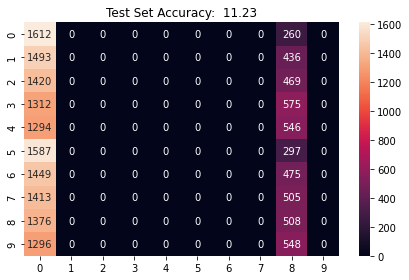

In [9]:
fingerNameStudy = {
    'datasets' : [
        ds.SOCOFingFingers(**datasetsConfig), 
        ds.NISTSDB4Fingers(**datasetsConfig), 
        ds.NISTSDB300aFingers(**datasetsConfig), 
        ds.NISTSDB302bFingers(**datasetsConfig)
    ],
    'studyHyperParameters' : {
        'defaultBackbone': {'backbone' : bb.MobileNetV2, 'weights' : weightsMNV2},
        'defaultClassifier': cf.DefaultClassifier,
        'defaultHypers': {
            "optimizer": Adam,
            "learningRate": 0.001,
            "loss": 'categorical_crossentropy',
            "metrics": 'accuracy'
        },
        'losses': ['mean_squared_error', 'categorical_hinge'],
        'learningRates': [0.1, 0.01, 0.0001, 0.00001],
        'optimizers': [Nadam, RMSprop],
        'classifiers': [cf.AlexNetClassifier, cf.MobileNetClassifier, cf.ResNetClassifier],
        'backbonesForSearch': [
            {'backbone' : bb.ResNet50, 'weights' : weightsRN50},
            {'backbone' : bb.EfficientNetB2, 'weights' : weightsENB2},
            {'backbone' : bb.InceptionV3, 'weights' : weightsINCEPTIONV3},
            {'backbone' : bb.Xception, 'weights' : weightsXCEPTION}, 
        ],
        'epochsSearch': 1,
        'epochsBest': 1,
        'verbose': 1
    }
}

  
fingersBestModels = researchStudy(fingerNameStudy, 1, dbStudyOutPath.format('FingerName/{}'))